In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
names_prods = ['Saving Accounts', 'Guarantees', 'Current Accounts', 'Derivada Account', 'Payroll Account', 'Junior Account',
               'Más particular Account', 'Particular Account', 'Particular Plus Account', 'Short-term deposits',
               'Medium-term deposits', 'Long-term deposits', 'e-account', 'Funds', 'Mortgage', 'Pensions', 'Loans', 'Taxes',
               'Credit Card', 'Securities', 'Home Account', 'Payroll', 'Pensions', 'Direct Debit']

### Carga de datos de entrenamiento y test

In [3]:
%%time
df = pd.read_csv('data/train_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df.head()

CPU times: user 1min 20s, sys: 5.64 s, total: 1min 25s
Wall time: 1min 40s


In [4]:
%%time
df_test = pd.read_csv('data/test_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df_test.head()

CPU times: user 4.23 s, sys: 60 ms, total: 4.29 s
Wall time: 4.29 s


In [5]:
df.shape, df_test.shape

((13647309, 48), (929615, 24))

### Exploración de productos por mes

In [19]:
products = df.loc[:, ['fecha_dato']].join(df.loc[:, 'ind_ahor_fin_ult1':])

In [20]:
products.shape

(13647309, 25)

##### Cantidad de productos cada mes

In [8]:
df_a = products.groupby(['fecha_dato']).sum()

In [223]:
#Descripción de los productos
descr_prods = {}
for i, p in enumerate(names_prods):
    descr_prods[df_a.columns.tolist()[i]] = { 'num': str(i+1), 'name': p }

In [10]:
dates = [d.strftime("%b %Y") for d in df_a.index]

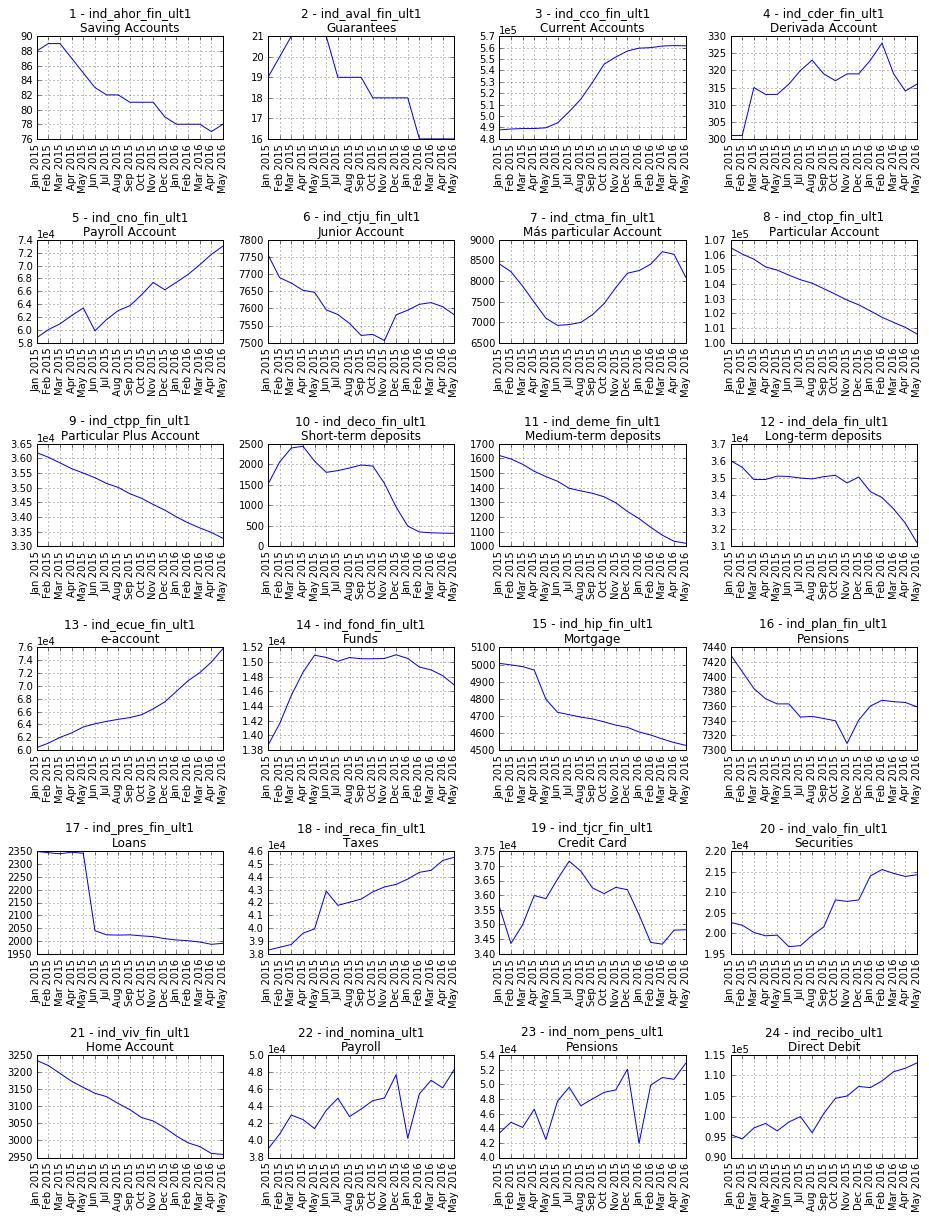

In [224]:
fig, axes = plt.subplots(6, 4, sharex=False, figsize=(13, 17))
axs = [j for i in axes for j in i]
for i, col in enumerate(df_a.columns):
    serie = df_a.loc[:, col]
    ax = axs[i]
    ax.plot(serie.values)
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels(dates, rotation=90)
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

### Compras y "abandonos" de productos por mes
En esta sección se mira el comportamiento de compra y abandono de cada producto por mes

In [227]:
df_b = pd.DataFrame(columns=df_a.columns.tolist()[0:]) #dataframe products prev bought
for i in range(1, len(dates)):
    prev_prods = df_a.loc[df_a.index[i-1]].as_matrix()
    act_prods = df_a.loc[df_a.index[i]].as_matrix()
    bought_prods = act_prods - prev_prods
    df_b.loc[i] = bought_prods

In [228]:
df_b = df_a.reset_index().loc[:, ['fecha_dato']].join(df_b).iloc[1:]
df_b = df_b.set_index('fecha_dato')

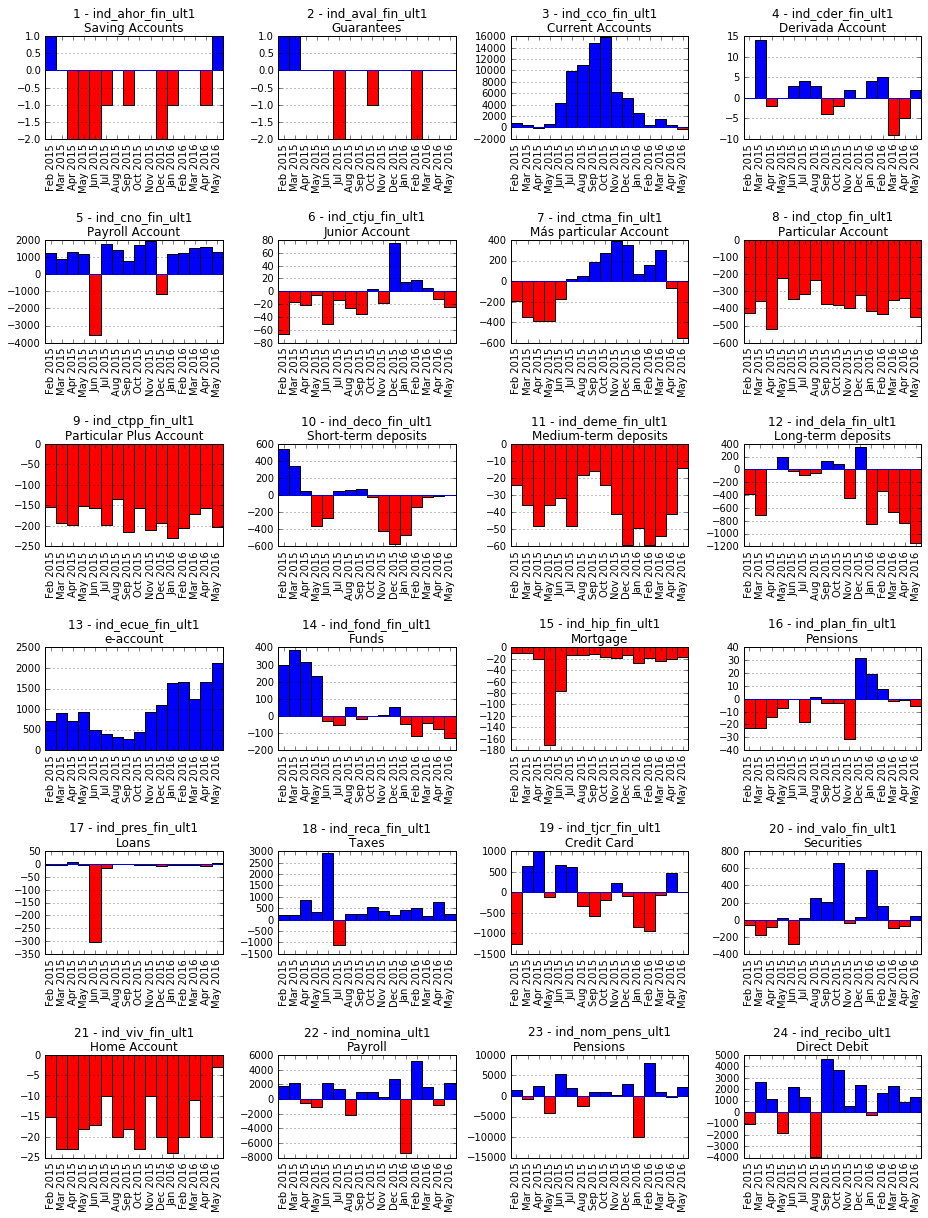

In [229]:
fig, axes = plt.subplots(6, 4, sharex=False, figsize=(13, 17))
axs = [j for i in axes for j in i]
for i, col in enumerate(df_b.columns):
    serie = df_b.loc[:, col]
    ax = axs[i]
    colors = list(map(lambda x: 'r' if x < 0 else 'b', serie.values))
    ax.bar(np.arange(len(serie)), serie, color=colors, width=1, align='center')
    #ax.plot(serie.values, c='r', linewidth=1.5)
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates[1:])))
    ax.set_xticklabels(dates[1:], rotation=90)
    ax.set_xlim(-0.5, len(serie.values)-0.5)
    ax.axhline()
    ax.grid(axis='y')
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

### Top 10 productos que los clientes tienen

In [230]:
top_products = [i for i in reversed(df_a.mean().sort_values()[-10:].index)]

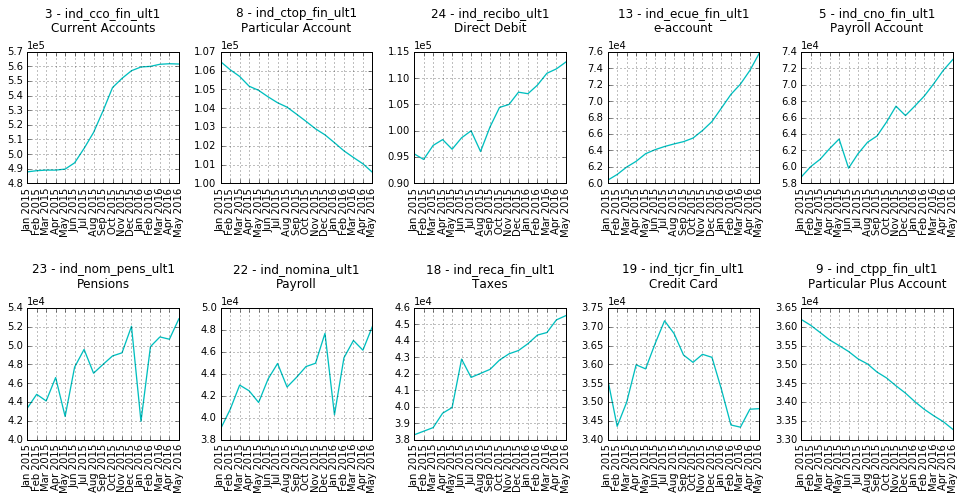

In [231]:
fig, axes = plt.subplots(2, 5, sharex=False, figsize=(13.5, 7))
axs = [j for i in axes for j in i]
for i, col in enumerate(top_products):
    serie = df_a.loc[:, col]
    ax = axs[i]
    ax.plot(serie.values, linewidth=1.3, c='c')
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'] + '\n')
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels(dates, rotation=90)
    #ax.axhline()
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=3)

### Top 10 productos más comprados

In [13]:
df_c = df_b.copy()
df_c[df_c < 0] = 0
top_purchases = df_c.mean().sort_values(ascending=False)[:10].index

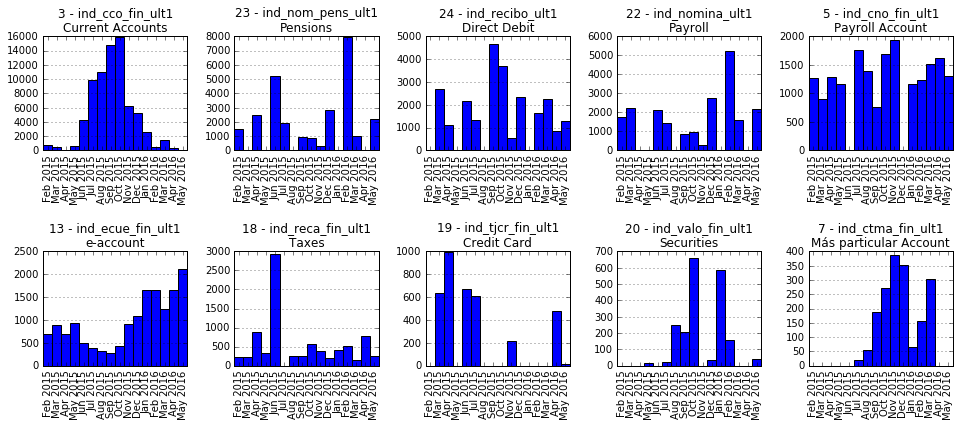

In [232]:
fig, axes = plt.subplots(2, 5, sharex=False, figsize=(13.5, 6))
axs = [j for i in axes for j in i]
for i, col in enumerate(top_purchases):
    serie = df_c.loc[:, col]
    ax = axs[i]
    colors = list(map(lambda x: 'r' if x < 0 else 'b', serie.values))
    ax.bar(np.arange(len(serie)), serie, color=colors, width=1, align='center')
    #ax.plot(serie.values, c='r', linewidth=1.5)
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates[1:])))
    ax.set_xticklabels(dates[1:], rotation=90)
    ax.set_xlim(-0.5, len(serie.values)-0.5)
    ax.axhline()
    ax.grid(axis='y')
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

## Renta
Se quiere reemplazar los datos de renta faltantes por los de la misma provincia

In [6]:
median_renta = df.groupby(['nomprov']).agg({'renta': 'median'})
median_renta.head()

,renta
nomprov,
ALAVA,96967.65
ALBACETE,78657.30
ALICANTE,67526.28
ALMERIA,73390.65
ASTURIAS,87199.38


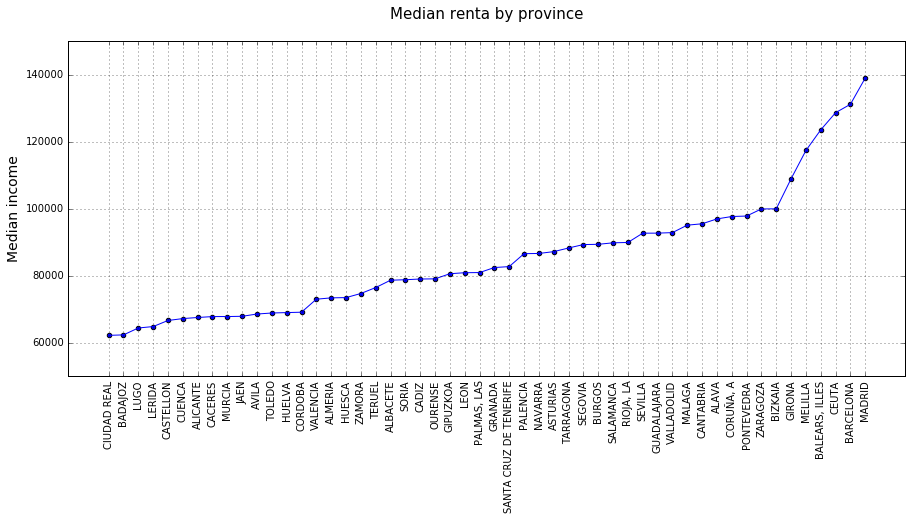

In [7]:
plt.figure(figsize=(15, 6))
serie = median_renta.sort_values(by='renta').renta
plt.plot(serie.values)

plt.xticks(range(len(serie)), serie.index, rotation=90)
plt.scatter(range(len(serie)), serie.values)
plt.title('Median renta by province\n', size=15)
plt.ylabel('Median income', size=14)
plt.grid()

### Comparación entre Mayo 2015 - Mayo 2016

In [11]:
may_15 = df[df['fecha_dato'] == '2015-05-28']
may_16 = df[df['fecha_dato'] == '2016-05-28']

In [53]:
may_union = may_15.append(may_16)
may_products = may_union.loc[:, ['fecha_dato']].join(may_union.loc[:, 'ind_ahor_fin_ult1':])

In [54]:
may_products = may_products.groupby(['fecha_dato']).agg('sum')

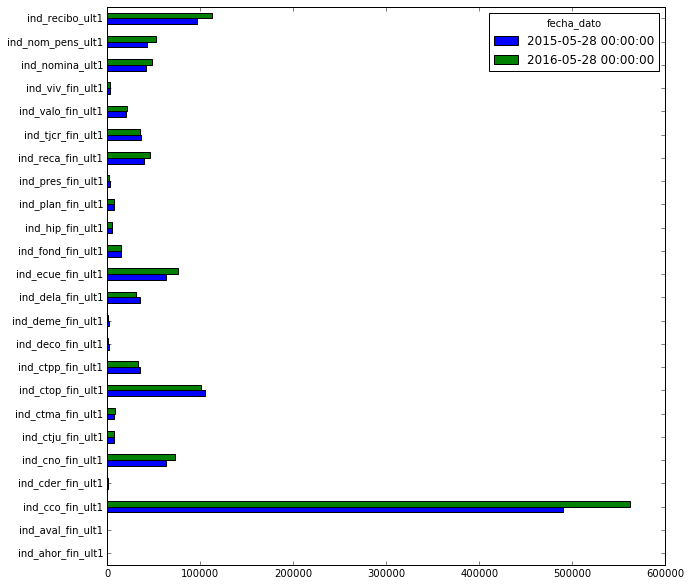

In [56]:
may_products.T.plot(kind='barh', figsize=(10, 10))

### Comparación entre Abril 2015 - Abril 2016